# <center> Проект: построе модели предсказывающей рейтинг отеля

In [155]:
import pandas as pd



In [158]:

hotels=pd.read_csv('data/hotels.csv')


In [120]:
# преобразуем данные в столбце days_since_review в числовой формат
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x: x.split()[0]).astype(int)


In [121]:
# Добавляем новые признаки
hotels['review_date'] = pd.to_datetime(hotels['review_date'])

#добавляем признак год размещения отзыва
hotels['review_year'] = hotels['review_date'].dt.year
hotels['review_month'] = hotels['review_date'].dt.month

# функция возвращает 0 если отзыв написан в холодное время года и 1 если в теплое
hotels['cold(0)/warm(1)_season'] = hotels['review_month'].apply(lambda x: 0 if x in [9, 10, 11, 12, 1, 2] else 1)

# удаляем лишние столбцы
hotels = hotels.drop(['review_date'], axis=1)

In [122]:
# Удаляем столбцы, данные в которых представлены не числами
object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
hotels.drop(object_columns, axis = 1, inplace=True)

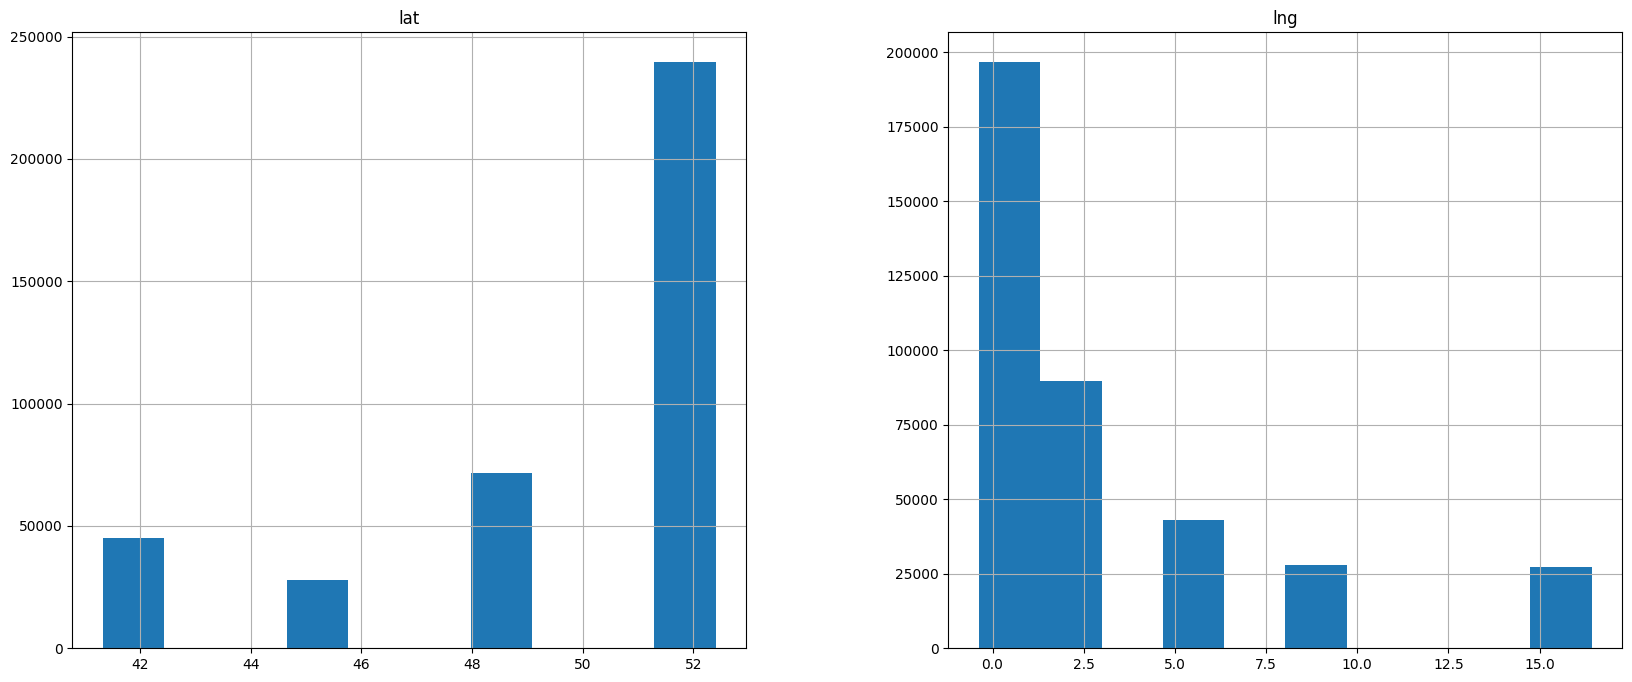

In [112]:
cols_null_percent = hotels.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)

cols = cols_with_null.index
hotels[cols].hist(figsize=(20, 8));


In [123]:
# Заполняем пропущенные значения 
values = {
    'lat': hotels['lat'].median(),
    'lng': hotels['lat'].median()
}
hotels = hotels.fillna(values)

In [127]:
from sklearn import preprocessing
col_names = list(hotels[['additional_number_of_scoring', 'total_number_of_reviews_reviewer_has_given', 'average_score',
       'review_total_negative_word_counts', 'review_total_positive_word_counts', 'total_number_of_reviews',
       'days_since_review', 'lat', 'lng']])

# инициализируем нормализатор RobustScaler
r_scaler = preprocessing.RobustScaler()

# кодируем исходный датасет
hotels_r = r_scaler.fit_transform(hotels[['additional_number_of_scoring', 'total_number_of_reviews_reviewer_has_given', 'average_score',
       'review_total_negative_word_counts', 'review_total_positive_word_counts', 'total_number_of_reviews',
       'days_since_review', 'lat', 'lng']])

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
hotels_r = pd.DataFrame(hotels_r, columns=col_names)

hotels[['additional_number_of_scoring', 'total_number_of_reviews_reviewer_has_given', 'average_score',
       'review_total_negative_word_counts', 'review_total_positive_word_counts', 'total_number_of_reviews',
       'days_since_review', 'lat', 'lng']] = hotels_r [['additional_number_of_scoring', 'total_number_of_reviews_reviewer_has_given', 'average_score',
       'review_total_negative_word_counts', 'review_total_positive_word_counts', 'total_number_of_reviews',
       'days_since_review', 'lat', 'lng']]


,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,days_since_review,lat,lng,review_year,review_month,cold(0)/warm(1)_season
count,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000
mean,0.318221,-0.003956,0.454238,0.248773,0.398646,0.596750,8.396906,0.003943,-0.618920,0.624247,2016.120707,6.489125,0.530182
std,1.018855,0.782687,1.414446,0.944721,1.278008,1.579203,1.636090,0.593679,1.047906,1.199295,0.687740,3.351116,0.499089
min,-0.694501,-4.571429,-0.428571,-0.852773,-0.647059,-0.285714,2.500000,-1.002841,-3.080787,-0.078171,2015.000000,1.000000,0.000000
25%,-0.352342,-0.428571,-0.333333,-0.396819,-0.352941,-0.285714,7.500000,-0.505682,-0.995061,-0.032753,2016.000000,4.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.800000,0.000000,0.000000,0.000000,2016.000000,7.000000,1.000000
75%,0.647658,0.571429,0.666667,0.603181,0.647059,0.714286,9.600000,0.494318,0.004939,0.967247,2017.000000,9.000000,1.000000
max,4.765784,2.000000,19.000000,5.928222,22.588235,50.285714,10.000000,1.071023,0.272654,10.327964,2017.000000,12.000000,1.000000


<Axes: >

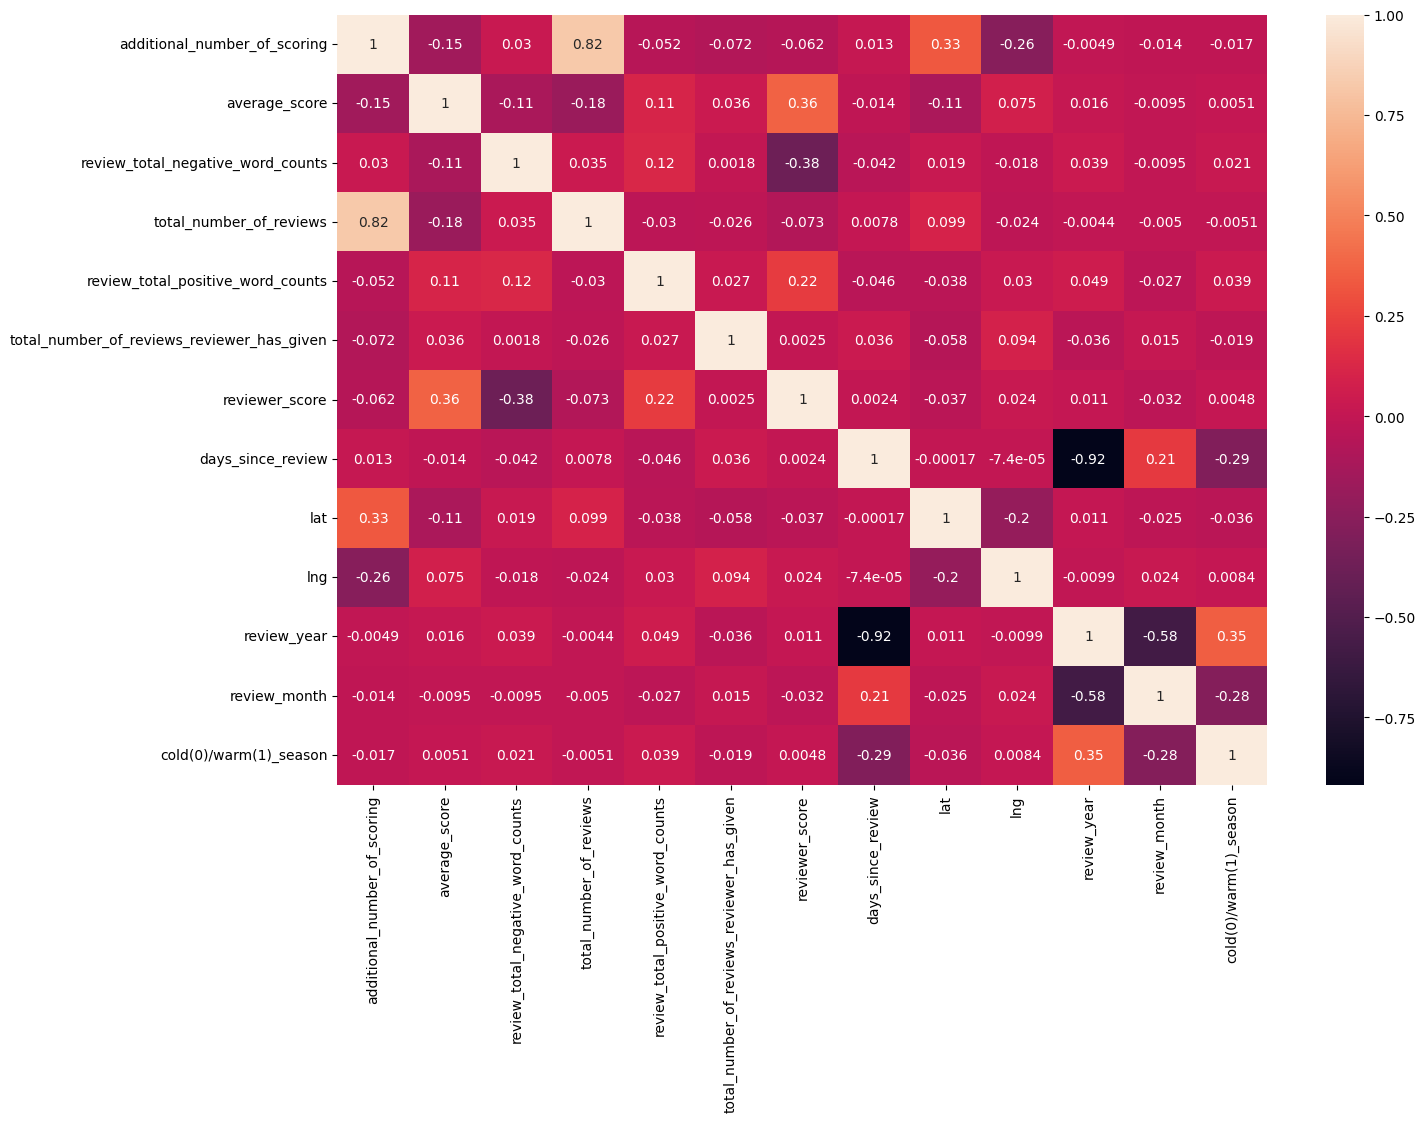

In [134]:
# Отбор признаков
import seaborn as sns 

fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(hotels.corr(), annot=True) 

In [136]:
hotels = hotels.drop(['additional_number_of_scoring', 'review_year'], axis=1)

In [137]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels['reviewer_score'] 

In [138]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

In [139]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [140]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  


In [141]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.1377043012680955
